**Run all cells as per stage wise instructions**

In [ ]:
!pip install gdown

In [ ]:
!pip install opendatasets

In [ ]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
import random
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import os , itertools
import matplotlib.pyplot as plt
import gdown
import opendatasets as od

In [37]:
#Maps to Satillite
!gdown --id 1FNCSuUi0d2Ujcx93h6hpTQ-pP28Vxwzd
!gdown --id 1OJtv95-9_tvdfsxt9R0UD2fZfb48wIFi
# Vangogh to Image
!gdown --id 1743-noabCOlRTmKaCJ9fQ5rLh30cnLgd
!gdown --id 1pjkUN_Y4vw9WI9_fF1yE8wM53fLUZwIC
# Summer To Winter
!gdown --id 1UnQd1biCMQmWGjdusrrki-DSyF9mY-79
!gdown --id 1zxBIxmHv7_QAK42N3uCTMFoyiJge5FH5
# Loss data file 
!gdown --id 1jAzjeHlyB-lQpHMtcFvFjBH5nFkuaFeh

Downloading...
From: https://drive.google.com/uc?id=1FNCSuUi0d2Ujcx93h6hpTQ-pP28Vxwzd
To: /content/genS.pth.tar
100% 39.4M/39.4M [00:00<00:00, 123MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1OJtv95-9_tvdfsxt9R0UD2fZfb48wIFi
To: /content/genM.pth.tar
100% 39.4M/39.4M [00:00<00:00, 125MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1743-noabCOlRTmKaCJ9fQ5rLh30cnLgd
To: /content/genV.pth.tar
100% 39.4M/39.4M [00:00<00:00, 147MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1pjkUN_Y4vw9WI9_fF1yE8wM53fLUZwIC
To: /content/genP.pth.tar
100% 39.4M/39.4M [00:00<00:00, 121MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1UnQd1biCMQmWGjdusrrki-DSyF9mY-79
To: /content/genWint.pth.tar
100% 39.4M/39.4M [00:00<00:00, 149MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zxBIxmHv7_QAK42N3uCTMFoyiJge5FH5
To: /content/genSum.pth.tar
100% 39.4M/39.4M [00:00<00:00, 149MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1jAzjeHlyB-lQpHMtcFvFjBH5n

In [ ]:
# dataset loading from kaggle
od.download('https://www.kaggle.com/suyashdamle/cyclegan?select=maps')
od.download('https://www.kaggle.com/suyashdamle/cyclegan?select=summer2winter_yosemite')
od.download('https://www.kaggle.com/suyashdamle/cyclegan?select=vangogh2photo')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Your Kaggle Key: Downloading cyclegan.zip to ./cyclegan


100%|██████████| 3.40G/3.40G [00:54<00:00, 66.5MB/s]



Skipping, found downloaded files in "./cyclegan" (use force=True to force download)
Skipping, found downloaded files in "./cyclegan" (use force=True to force download)


#.......................Attention Required..................#

**PLEASE SELECT NUMBER OF EPOCHS**

In [ ]:
parameters = {
    'Num_Of_Epochs':1,     # NUMBER OF EPOCHS
    'batch_size':1,
    'input_size':256,
    'ResizeScale':286,
    'CropSize':256,
    'LearningRate_Flip':True,
    'Decay_start_epoch':440,
    'num_gen_filters':32,   #number of generator filters
    'num_disc_filters':64,   #number of discriminator filters
    'Num_Of_Resnet':6, #number of resnet blocks
    'LearningRate_Gen':0.0002,    #learning rate for generator
    'LearningRate_Disc':0.0002,    #learning rate for discriminator
    'beta_1':0.5 ,    #beta_1 for Adam optimizer
    'beta_2':0.999 ,  #beta_2 for Adam optimizer
    'lambda_A':10 ,   #lambda_A for cycle loss
    'lambda_B':10  ,  #lambda_B for cycle loss
    'LOAD_MODEL':True,
    'SAVE_MODEL':False
}
print('Please read below content')

Please read below content


**.........................ATTENTION-1 REQUIRED....................**

CycleGAN is experimented on three data sets

1) Arial2Satellite or Maps dataset

2) Summer2Winter dataset

3) Vangogh2Images dataset  

Select choice as per the order each time one data set directory and check points are loaded .

*Example*: If you give 1 , Maps data set and checkpoints directory is loaded for the task

In [15]:
choice=int(input())
print('Your Choice is :',choice)

1
Your Choice is : 1


In [16]:
if choice== 1:
    checkpoint_generator_M = "/content/genM.pth.tar"
    checkpoint_generator_S = "/content/genS.pth.tar"
    data_dir = '/content/cyclegan/maps/maps'
    print('Arial2Satellite>>>>>>>Check points and data set directory is loaded successfully')
if choice == 2:
    checkpoint_generator_M = "/content/genSum.pth.tar"
    checkpoint_generator_S = "/content/genWint.pth.tar"
    data_dir = '/content/cyclegan/summer2winter_yosemite/summer2winter_yosemite'
    print('Summer2Winter>>>>>>>>>Check points and data set directory is  is loaded successfully')
if choice ==3:
    checkpoint_generator_M = "/content/genV.pth.tar"
    checkpoint_generator_S = "/content/genP.pth.tar"
    data_dir = '/content/cyclegan/vangogh2photo/vangogh2photo'
    print('Vangogh2Image>>>>>>>>>Check points and data set directory is  is loaded successfully')
    
   

Arial2Satellite>>>>>>>Check points and data set directory is loaded successfully


In [17]:
def to_np(x):
    return x.data.cpu().numpy()

In [18]:
def Display_Results(real_image, gen_image, recon_image, epoch, show=True, fig_size=(15, 15)):
    fig, axes = plt.subplots(2, 3, figsize=fig_size)
    imgs = [to_np(real_image[0]), to_np(gen_image[0]), to_np(recon_image[0]),
            to_np(real_image[1]), to_np(gen_image[1]), to_np(recon_image[1])]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('on')
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    title = 'Image at epoch {0}'.format(epoch + 1)
    fig.text(0.5, 0.04, title, ha='center')

    if show:
        plt.show()
    else:
        plt.close()

In [19]:
class ImageBuffer():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

In [20]:
class DatasetLoadFromFolder(data.Dataset):
    def __init__(self, image_dir, subfolder='train', transform=None, ResizeScale=None, CropSize=None, LearningRate_Flip=False):
        super(DatasetLoadFromFolder, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.image_filenames = [x for x in sorted(os.listdir(self.input_path))]
        self.transform = transform
        
        self.ResizeScale = ResizeScale
        self.CropSize = CropSize
        self.LearningRate_Flip = LearningRate_Flip

    def __getitem__(self, index):
        # Load Image
        img_fn = os.path.join(self.input_path, self.image_filenames[index])
        img = Image.open(img_fn).convert('RGB')

        # preprocessing
        if self.ResizeScale:
            img = img.resize((self.ResizeScale, self.ResizeScale), Image.BILINEAR)

        if self.CropSize:
            x = random.randint(0, self.ResizeScale - self.CropSize + 1)
            y = random.randint(0, self.ResizeScale - self.CropSize + 1)
            img = img.crop((x, y, x + self.CropSize, y + self.CropSize))
        if self.LearningRate_Flip:
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.image_filenames)


In [21]:
class ConvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,activation='relu',batch_norm=True):
        super(ConvBlock,self).__init__()
        self.conv = torch.nn.Conv2d(input_size,output_size,kernel_size,stride,padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
        self.lrelu = torch.nn.LeakyReLU(0.2,True)
        self.tanh = torch.nn.Tanh()
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.conv(x))
        else:
            out = self.conv(x)
        
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out

In [22]:
class DeconvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,output_padding=1,activation='relu',batch_norm=True):
        super(DeconvBlock,self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size,output_size,kernel_size,stride,padding,output_padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.deconv(x))
        else:
            out = self.deconv(x)
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out

In [23]:
class ResnetBlock(torch.nn.Module):
    def __init__(self,num_filter,kernel_size=3,stride=1,padding=0):
        super(ResnetBlock,self).__init__()
        conv1 = torch.nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding)
        conv2 = torch.nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding)
        bn = torch.nn.InstanceNorm2d(num_filter)
        relu = torch.nn.ReLU(True)
        pad = torch.nn.ReflectionPad2d(1)
        
        self.resnet_block = torch.nn.Sequential(pad,conv1,bn,relu,pad,conv2,bn)
    def forward(self,x):
        out = self.resnet_block(x)
        return out

In [24]:
class Generator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim,Num_Of_Resnet):
        super(Generator,self).__init__()
        
        #Reflection padding
        self.pad = torch.nn.ReflectionPad2d(3)
        #Encoder
        self.conv1 = ConvBlock(input_dim,num_filter,kernel_size=7,stride=1,padding=0)
        self.conv2 = ConvBlock(num_filter,num_filter*2)
        self.conv3 = ConvBlock(num_filter*2,num_filter*4)
        #Resnet blocks
        self.resnet_blocks = []
        for i in range(Num_Of_Resnet):
            self.resnet_blocks.append(ResnetBlock(num_filter*4))
        self.resnet_blocks = torch.nn.Sequential(*self.resnet_blocks)
        #Decoder
        self.deconv1 = DeconvBlock(num_filter*4,num_filter*2)
        self.deconv2 = DeconvBlock(num_filter*2,num_filter)
        self.deconv3 = ConvBlock(num_filter,output_dim,kernel_size=7,stride=1,padding=0,activation='tanh',batch_norm=False)
    
    def forward(self,x):
        #Encoder
        enc1 = self.conv1(self.pad(x))
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        #Resnet blocks
        res = self.resnet_blocks(enc3)
        #Decoder
        dec1 = self.deconv1(res)
        dec2 = self.deconv2(dec1)
        out = self.deconv3(self.pad(dec2))
        return out
    
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
            if isinstance(m,DeconvBlock):
                torch.nn.init.normal_(m.deconv.weight,mean,std)
            if isinstance(m,ResnetBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
                torch.nn.init.constant_(m.conv.bias,0)

In [25]:
class Discriminator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim):
        super(Discriminator,self).__init__()
        conv1 = ConvBlock(input_dim,num_filter,kernel_size=4,stride=2,padding=1,activation='lrelu',batch_norm=False)
        conv2 = ConvBlock(num_filter,num_filter*2,kernel_size=4,stride=2,padding=1,activation='lrelu')
        conv3 = ConvBlock(num_filter*2,num_filter*4,kernel_size=4,stride=2,padding=1,activation='lrelu')
        conv4 = ConvBlock(num_filter*4,num_filter*8,kernel_size=4,stride=1,padding=1,activation='lrelu')
        conv5 = ConvBlock(num_filter*8,output_dim,kernel_size=4,stride=1,padding=1,activation='no_act',batch_norm=False)
        self.conv_blocks = torch.nn.Sequential(conv1,conv2,conv3,conv4,conv5)
    def forward(self,x):
        out = self.conv_blocks(x)
        return out
        
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight.data,mean,std)

In [26]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
transform = transforms.Compose([
    transforms.Resize(size=parameters['input_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_data_A = DatasetLoadFromFolder(data_dir, subfolder='trainA', transform=transform,
                                ResizeScale=parameters['ResizeScale'], CropSize=parameters['CropSize'], LearningRate_Flip=parameters['LearningRate_Flip'])
train_data_loader_A = torch.utils.data.DataLoader(dataset=train_data_A, batch_size=parameters['batch_size'],num_workers=2, shuffle=True)
train_data_B = DatasetLoadFromFolder(data_dir, subfolder='trainB', transform=transform,
                                ResizeScale=parameters['ResizeScale'], CropSize=parameters['CropSize'], LearningRate_Flip=parameters['LearningRate_Flip'])
train_data_loader_B = torch.utils.data.DataLoader(dataset=train_data_B, batch_size=parameters['batch_size'],num_workers=2, shuffle=True)
#Load test data
test_data_A = DatasetLoadFromFolder(data_dir, subfolder='testA', transform=transform)
test_data_loader_A = torch.utils.data.DataLoader(dataset=test_data_A, batch_size=parameters['batch_size'],num_workers=2,shuffle=False)
test_data_B = DatasetLoadFromFolder(data_dir, subfolder='testB', transform=transform)
test_data_loader_B = torch.utils.data.DataLoader(dataset=test_data_B, batch_size=parameters['batch_size'],num_workers=2,shuffle=False)

In [29]:
#Build Model 
G_A = Generator(3, parameters['num_gen_filters'], 3, parameters['Num_Of_Resnet']).cuda() # input_dim, num_filter, output_dim, Num_Of_Resnet
G_B = Generator(3, parameters['num_gen_filters'], 3, parameters['Num_Of_Resnet']).cuda()

D_A = Discriminator(3, parameters['num_disc_filters'], 1).cuda() # input_dim, num_filter, output_dim
D_B = Discriminator(3, parameters['num_disc_filters'], 1).cuda()

G_A.normal_weight_init(mean=0.0, std=0.02)
G_B.normal_weight_init(mean=0.0, std=0.02)
D_A.normal_weight_init(mean=0.0, std=0.02)
D_B.normal_weight_init(mean=0.0, std=0.02)

In [30]:
G_optimizer = torch.optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()), lr=parameters['LearningRate_Gen'], betas=(parameters['beta_1'], parameters['beta_2']))
D_A_optimizer = torch.optim.Adam(D_A.parameters(), lr=parameters['LearningRate_Disc'], betas=(parameters['beta_1'], parameters['beta_2']))
D_B_optimizer = torch.optim.Adam(D_B.parameters(), lr=parameters['LearningRate_Disc'], betas=(parameters['beta_1'], parameters['beta_2']))

In [31]:
MSE_Loss = torch.nn.MSELoss().cuda()
L1_Loss = torch.nn.L1Loss().cuda()

# # Training GAN
Discriminator_A_average_losses = []
Discriminator_B_average_losses = []
Generator_A_average_losses = []
Generator_B_average_losses = []
cycle_A_average_losses = []
cycle_B_average_losses = []

In [32]:
if parameters['LOAD_MODEL']:
    load_checkpoint(
        checkpoint_generator_M, G_A, G_optimizer,parameters['LearningRate_Gen'],
    )
    load_checkpoint(
        checkpoint_generator_S, G_B, G_optimizer,parameters['LearningRate_Gen'],
    )
   

=> Loading checkpoint
=> Loading checkpoint


# **..................Attention-2....................**



1.   Exicute Cell-1 and Cell-2 for **tarining** and **testing** both.
         OR
2.   Exicute Cell-3 amd Cell-4 for **only testing** on saved checkpoints.




**Cell-1**

In [33]:
test_real_A_data = train_data_A.__getitem__(17).unsqueeze(0) # Convert to 4d tensor 
test_real_B_data = train_data_B.__getitem__(16).unsqueeze(0)

**Cell-2**

*Training_Section*

training started
Epoch [1/1], Step [1096/1096], D_A_loss: 0.2626, D_B_loss: 0.2524, G_A_loss: 0.2220, G_B_loss: 0.1819


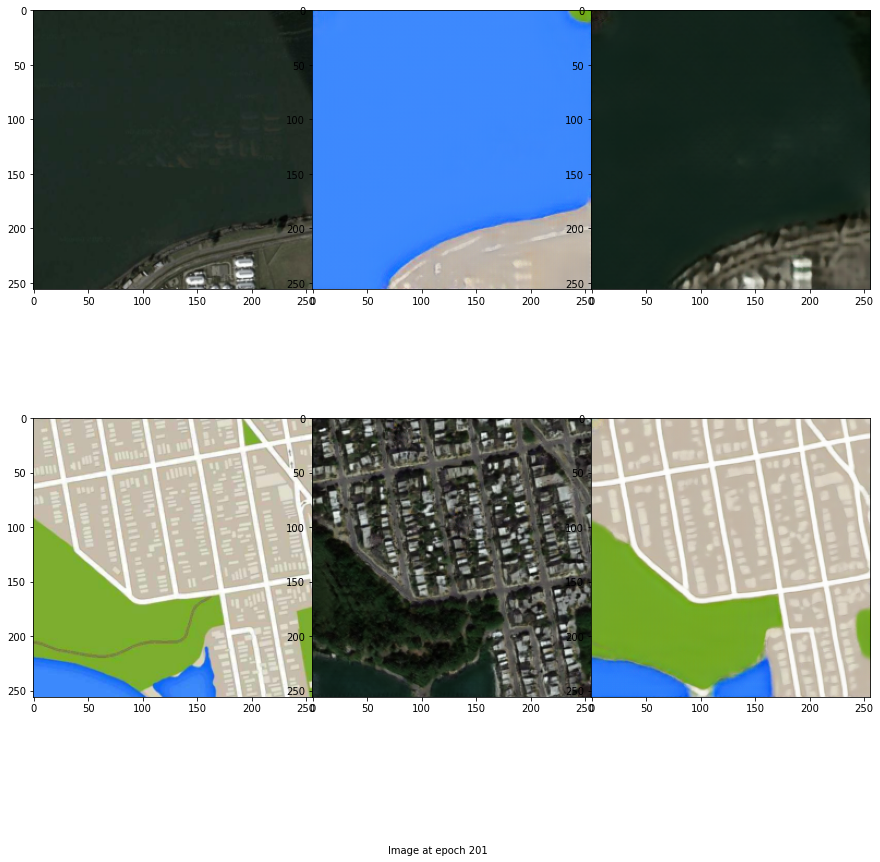

In [34]:
# Generated image pool
num_pool = 50
fake_A_pool = ImageBuffer(num_pool)
fake_B_pool = ImageBuffer(num_pool)
loss_df = pd.DataFrame(columns=['D_A_losses','D_B_losses','G_A_losses','G_B_losses','cycle_A_losses','cycle_B_losses'])
step = 0
for epoch in range(parameters['Num_Of_Epochs']):
    G_A.train()
    G_B.train()
    
    D_A_losses = []
    D_B_losses = []
    G_A_losses = []
    G_B_losses = []
    cycle_A_losses = []
    cycle_B_losses = []
    print('training started')
    # Learing rate decay 
    if(epoch + 1) > parameters['Decay_start_epoch']:
        D_A_optimizer.param_groups[0]['lr'] -= parameters['LearningRate_Disc'] / (parameters['Num_Of_Epochs'] - parameters['Decay_start_epoch'])
        D_B_optimizer.param_groups[0]['lr'] -= parameters['LearningRate_Disc'] / (parameters['Num_Of_Epochs'] - parameters['Decay_start_epoch'])
        G_optimizer.param_groups[0]['lr'] -= parameters['LearningRate_Gen'] / (parameters['Num_Of_Epochs'] - parameters['Decay_start_epoch'])
        
    
    # training 
    for i, (real_A, real_B) in enumerate(zip(train_data_loader_A, train_data_loader_B)):
        
        # input image data
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        
        
        # -------------------------- train generator G --------------------------
        # A --> B
        fake_B = G_A(real_A)
        D_B_fake_decision = D_B(fake_B)
        G_A_loss = MSE_Loss(D_B_fake_decision, Variable(torch.ones(D_B_fake_decision.size()).cuda()))
        
        # forward cycle loss
        recon_A = G_B(fake_B)
        cycle_A_loss = L1_Loss(recon_A, real_A) * parameters['lambda_A']
        
        # B --> A
        fake_A = G_B(real_B)
        D_A_fake_decision = D_A(fake_A)
        G_B_loss = MSE_Loss(D_A_fake_decision, Variable(torch.ones(D_A_fake_decision.size()).cuda()))
        
        # backward cycle loss
        recon_B = G_A(fake_A)
        cycle_B_loss = L1_Loss(recon_B, real_B) * parameters['lambda_B']
        
        # Back propagation
        G_loss = G_A_loss + G_B_loss + cycle_A_loss + cycle_B_loss
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        
        # -------------------------- train discriminator D_A --------------------------
        D_A_real_decision = D_A(real_A)
        D_A_real_loss = MSE_Loss(D_A_real_decision, Variable(torch.ones(D_A_real_decision.size()).cuda()))
        
        fake_A = fake_A_pool.query(fake_A)
        
        D_A_fake_decision = D_A(fake_A)
        D_A_fake_loss = MSE_Loss(D_A_fake_decision, Variable(torch.zeros(D_A_fake_decision.size()).cuda()))
        
        # Back propagation
        D_A_loss = (D_A_real_loss + D_A_fake_loss) * 0.5
        D_A_optimizer.zero_grad()
        D_A_loss.backward()
        D_A_optimizer.step()
        
        # -------------------------- train discriminator D_B --------------------------
        D_B_real_decision = D_B(real_B)
        D_B_real_loss = MSE_Loss(D_B_real_decision, Variable(torch.ones(D_B_fake_decision.size()).cuda()))
        
        fake_B = fake_B_pool.query(fake_B)
        
        D_B_fake_decision = D_B(fake_B)
        D_B_fake_loss = MSE_Loss(D_B_fake_decision, Variable(torch.zeros(D_B_fake_decision.size()).cuda()))
        
       
        
        # Back propagation
        D_B_loss = (D_B_real_loss + D_B_fake_loss) * 0.5
        D_B_optimizer.zero_grad()
        D_B_loss.backward()
        D_B_optimizer.step()
        
        # ------------------------ Print -----------------------------
        # loss values
        D_A_losses.append(D_A_loss.item())
        D_B_losses.append(D_B_loss.item())
        G_A_losses.append(G_A_loss.item())
        G_B_losses.append(G_B_loss.item())
        cycle_A_losses.append(cycle_A_loss.item())
        cycle_B_losses.append(cycle_B_loss.item())

       
           
            
        step += 1
    if epoch%3==0 and parameters['SAVE_MODEL'] :
        save_checkpoint(G_A, G_optimizer, filename=checkpoint_generator_M)
        save_checkpoint(G_B, G_optimizer, filename=checkpoint_generator_S)
        save_checkpoint(D_A, D_A_optimizer, filename=CHECKPOINT_CRITIC_H)
        save_checkpoint(D_B, D_B_optimizer, filename=CHECKPOINT_CRITIC_Z)
    print('Epoch [%d/%d], Step [%d/%d], D_A_loss: %.4f, D_B_loss: %.4f, G_A_loss: %.4f, G_B_loss: %.4f'
                  % (epoch+1, parameters['Num_Of_Epochs'], i+1, len(train_data_loader_A), D_A_loss.item(), D_B_loss.item(), G_A_loss.item(), G_B_loss.item()))  
    
    
    Discriminator_A_averageg_loss = torch.mean(torch.FloatTensor(D_A_losses))
    Discriminator_B_averageg_loss = torch.mean(torch.FloatTensor(D_B_losses))
    Generator_A_average_loss = torch.mean(torch.FloatTensor(G_A_losses))
    Generator_B_average_loss = torch.mean(torch.FloatTensor(G_B_losses))
    cycle_A_average_loss = torch.mean(torch.FloatTensor(cycle_A_losses))
    cycle_B_average_loss = torch.mean(torch.FloatTensor(cycle_B_losses))

    # avg loss values for plot
    Discriminator_A_average_losses.append(Discriminator_A_averageg_loss.item())
    Discriminator_B_average_losses.append(Discriminator_B_averageg_loss.item())
    Generator_A_average_losses.append(Generator_A_average_loss.item())
    Generator_B_average_losses.append(Generator_B_average_loss.item())
    cycle_A_average_losses.append(cycle_A_average_loss.item())
    cycle_B_average_losses.append(cycle_B_average_loss.item())
    
    
        # avg loss values for plot
    loss_df.loc[len(loss_df)] = [Discriminator_A_averageg_loss.item(),Discriminator_B_averageg_loss.item(),Generator_A_average_loss.item(),Generator_B_average_loss.item(),cycle_A_average_loss.item(),cycle_B_average_loss.item()]
    
    loss_df.to_csv('Loss_CycleGAN.csv',index=False)
    with torch.no_grad():
        G_A.eval()
        G_B.eval()
        # Show result for test image
        test_real_A = test_real_A_data.cuda()
        test_fake_B = G_A(test_real_A)
        test_recon_A = G_B(test_fake_B)

        test_real_B = test_real_B_data.cuda()
        test_fake_A = G_B(test_real_B)
        test_recon_B = G_A(test_fake_A)

        Display_Results([test_real_A, test_real_B], [test_fake_B, test_fake_A], [test_recon_A, test_recon_B],
                                200)


# **...................Attention-3.................**

*Testing section*


1.   you can change getitem value to some other digit to test on multiple test images
2.  Suggested range of input values below 150



**Cell-3**

In [35]:
test_real_A_data = train_data_A.__getitem__(35).unsqueeze(0) 
test_real_B_data = train_data_B.__getitem__(44).unsqueeze(0)

**Cell-4**

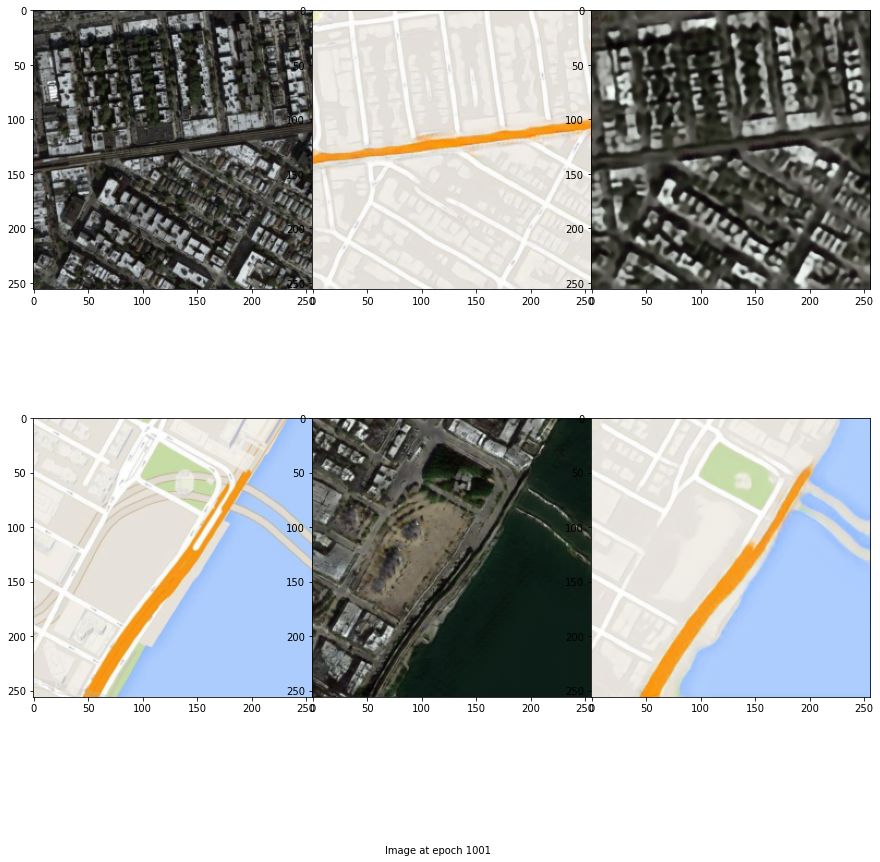

In [36]:

# Show result for test image
test_real_A = test_real_A_data.cuda()
test_fake_B = G_A(test_real_A)
test_recon_A = G_B(test_fake_B)

test_real_B = test_real_B_data.cuda()
test_fake_A = G_B(test_real_B)
test_recon_B = G_A(test_fake_A)

Display_Results([test_real_A, test_real_B], [test_fake_B, test_fake_A], [test_recon_A, test_recon_B],
                        epoch=1000)

# .......Attention-4......

NOTE:  plots for **Summer to Winter dataset**

In [38]:
df_loss = pd.read_csv('Loss_data-SW.csv')
d_A_loss = df_loss['D_A_losses']
d_B_loss = df_loss['D_B_losses']
g_A_loss = df_loss['G_A_losses']
g_B_loss = df_loss['G_B_losses']
cycle_A_loss=df_loss['cycle_A_losses']
cycle_B_loss=df_loss['cycle_B_losses']

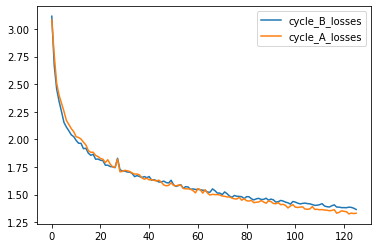

In [39]:
plt.plot(cycle_B_loss,label='cycle_B_losses')
plt.plot(cycle_A_loss,label='cycle_A_losses')
plt.legend()
plt.show()

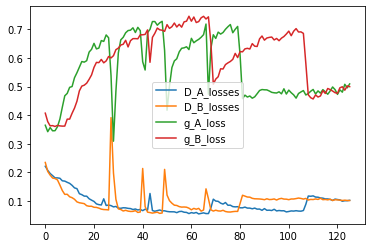

In [40]:
plt.plot(d_A_loss,label='D_A_losses')
plt.plot(d_B_loss,label='D_B_losses')
plt.plot(g_A_loss,label='g_A_loss')
plt.plot(g_B_loss,label='g_B_loss')
plt.legend()
plt.show()